In [3]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
from dask.diagnostics import ProgressBar
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
import seaborn as sns



from multiprocessing import cpu_count
from operator import concat
from typing import Callable, Sequence, Type, TypeVar

import pandas as pd
from boltons.iterutils import chunked_iter
from ctxcore.genesig import GeneSignature, Regulon
from ctxcore.rnkdb import MemoryDecorator, RankingDatabase
from dask import delayed
from dask.dataframe import from_delayed
from dask.distributed import Client, LocalCluster
from multiprocessing_on_dill.connection import Pipe
from multiprocessing_on_dill.context import Process




In [4]:
#pip install dask-expr==0.5.3 distributed==2024.2.1 #deal with DASK issues due to recent updates to DASK

In [25]:
adata = sc.read('/u/scratch/p/priyalsh/tcell_for_pyscenic_steps.h5ad')

In [5]:
# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "tcell_for_pyscenic.loom" # test dataset, n=500 cells
f_loom_path_scenic = "tcell_for_pyscenic.loom"
# path to pyscenic output
f_pyscenic_output = "pyscenic_output.loom"

In [6]:
#ls

In [7]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.10.9
scanpy      1.10.3
-----
MulticoreTSNE               NA
PIL                         8.3.1
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
boltons                     NA
certifi                     2021.05.30
cffi                        1.14.6
charset_normalizer          2.0.4
click                       8.1.8
cloudpickle                 3.1.1
ctxcore                     0.2.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     1.0.1
dask                        2024.2.1
dateutil                    2.8.2
decorator                   5.0.9
defusedxml                  0.7.1
dill                        0.3.9
distributed                 2024.2.1
entrypoints                 0.3
exceptiongroup              1.2.2
frozendict                  2.4.6
fsspec                      2025.2.0
h5py                        3.13

In [8]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

## write to an unfiltered loom file

row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
    "stimulation": np.array(adata.obs.stimulation),
    "cd_status": np.array(adata.obs.cd_status)
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

# FILTERING 

In [8]:
#len(allTFs_hg38.txt.1)

# SCENIC Steps

## STEP 1: Gene regulatory network inference, and generation of co-expression modules

### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier. Output: List of adjacencies between a TF and its targets stored in ADJACENCIES_FNAME.

In [9]:
f_tfs = '/u/home/p/priyalsh/allTFs_hg38.txt.1'
#pyscenic grn {tcell_for_pyscenic.loom} {allTFs_hg38.txt.1} -o adj.csv --num_workers 20

In [10]:
with open('/u/home/p/priyalsh/allTFs_hg38.txt.1', "r") as f:
    contents = f.read()
    
    

In [18]:
ls

adj.csv                              pbmc10k_filtered_scenic.loom
allTFs_hg38.txt                      pbmc10k_unfiltered.loom
allTFs_hg38.txt.1                    project-mcdb@
Cell_Oracle2.ipynb                   pysam/
Cell_Oracle.ipynb                    pyscenic.ipynb
celloracle_ubuntu_0.18.0.sif*        Pyscenic.ipynb
expr_mat.loom                        Pyscenic_Preprocessing_Steps.ipynb
filtering_panel_postfilter.pdf       pyscenic_with_new_package.ipynb
filtering_panel_prefilter.pdf        reg.csv
Main Pyscenic Steps.ipynb            scimilarity/
--method                             --seed
miniconda3/                          tcell_for_pyscenic.loom
Miniconda3-latest-Linux-x86_64.sh    tcell_hoffman_filtered.loom
Miniconda3-latest-Linux-x86_64.sh.1  Untitled1.ipynb
Miniconda3-latest-Linux-x86_64.sh.2  Untitled3.ipynb
Miniconda3-latest-Linux-x86_64.sh.3  Untitled4.ipynb
Miniconda3-latest-Linux-x86_64.sh.4  Untitled5.ipynb
Miniconda3-latest-Linux-x86_64.sh.5  Untitled6.ipynb
Mod

In [11]:
#!pyscenic grn tcell_for_pyscenic.loom allTFs_hg38.txt.1 -o adj.csv --num_workers 20

read in the adj. matrix

In [21]:
import pandas as pd
adjacencies = pd.read_csv("/u/scratch/p/priyalsh/adj_draft.csv")

In [22]:
adjacencies.head()

,TF,target,importance
0,BACH1,RP11-1143G9.4,7.951264
1,NF1,MS4A6A,7.357305
2,ZNF445,PLXNA3,7.058632
3,ZNF445,TLR5,7.049752
4,ZNF445,SNAI3,6.917426


# STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

Output: List of adjacencies between a TF and its targets stored in MOTIFS_FNAME.

locations for ranking databases, and motif annotations:

In [23]:
import glob
# ranking databases
f_db_glob = "/u/scratch/p/priyalsh/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/u/scratch/p/priyalsh/motifs-v9-nr.hgnc-m0.001-o0.0.feather"

In [24]:
#!pyscenic ctx /u/scratch/p/priyalsh/adj_draft.csv \
#    /u/scratch/p/priyalsh/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather \
#    --annotations_fname /u/scratch/p/priyalsh/motifs-v9-nr.hgnc-m0.001-o0.0.feather \
#    --expression_mtx_fname /u/home/p/priyalsh/tcell_for_pyscenic.loom \
#    --output reg.csv \
#    --mask_dropouts \
#    --num_workers 20

# STEP 4: Cellular enrichment (aka AUCell) from CLI

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. The following histogram gives an idea of the distribution and allows selection of an appropriate threshold. In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses). See the relevant section in the R tutorial for more information.

By using the default setting for --auc_threshold of 0.05, we see that 1192 genes are selected for the rankings based on the plot below.

In [27]:

nGenesDetectedPerCell = np.sum(adata.X > 0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCell)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)


0.01     496.0
0.05     603.0
0.10     713.0
0.50    1131.0
1.00    7475.0
dtype: float64


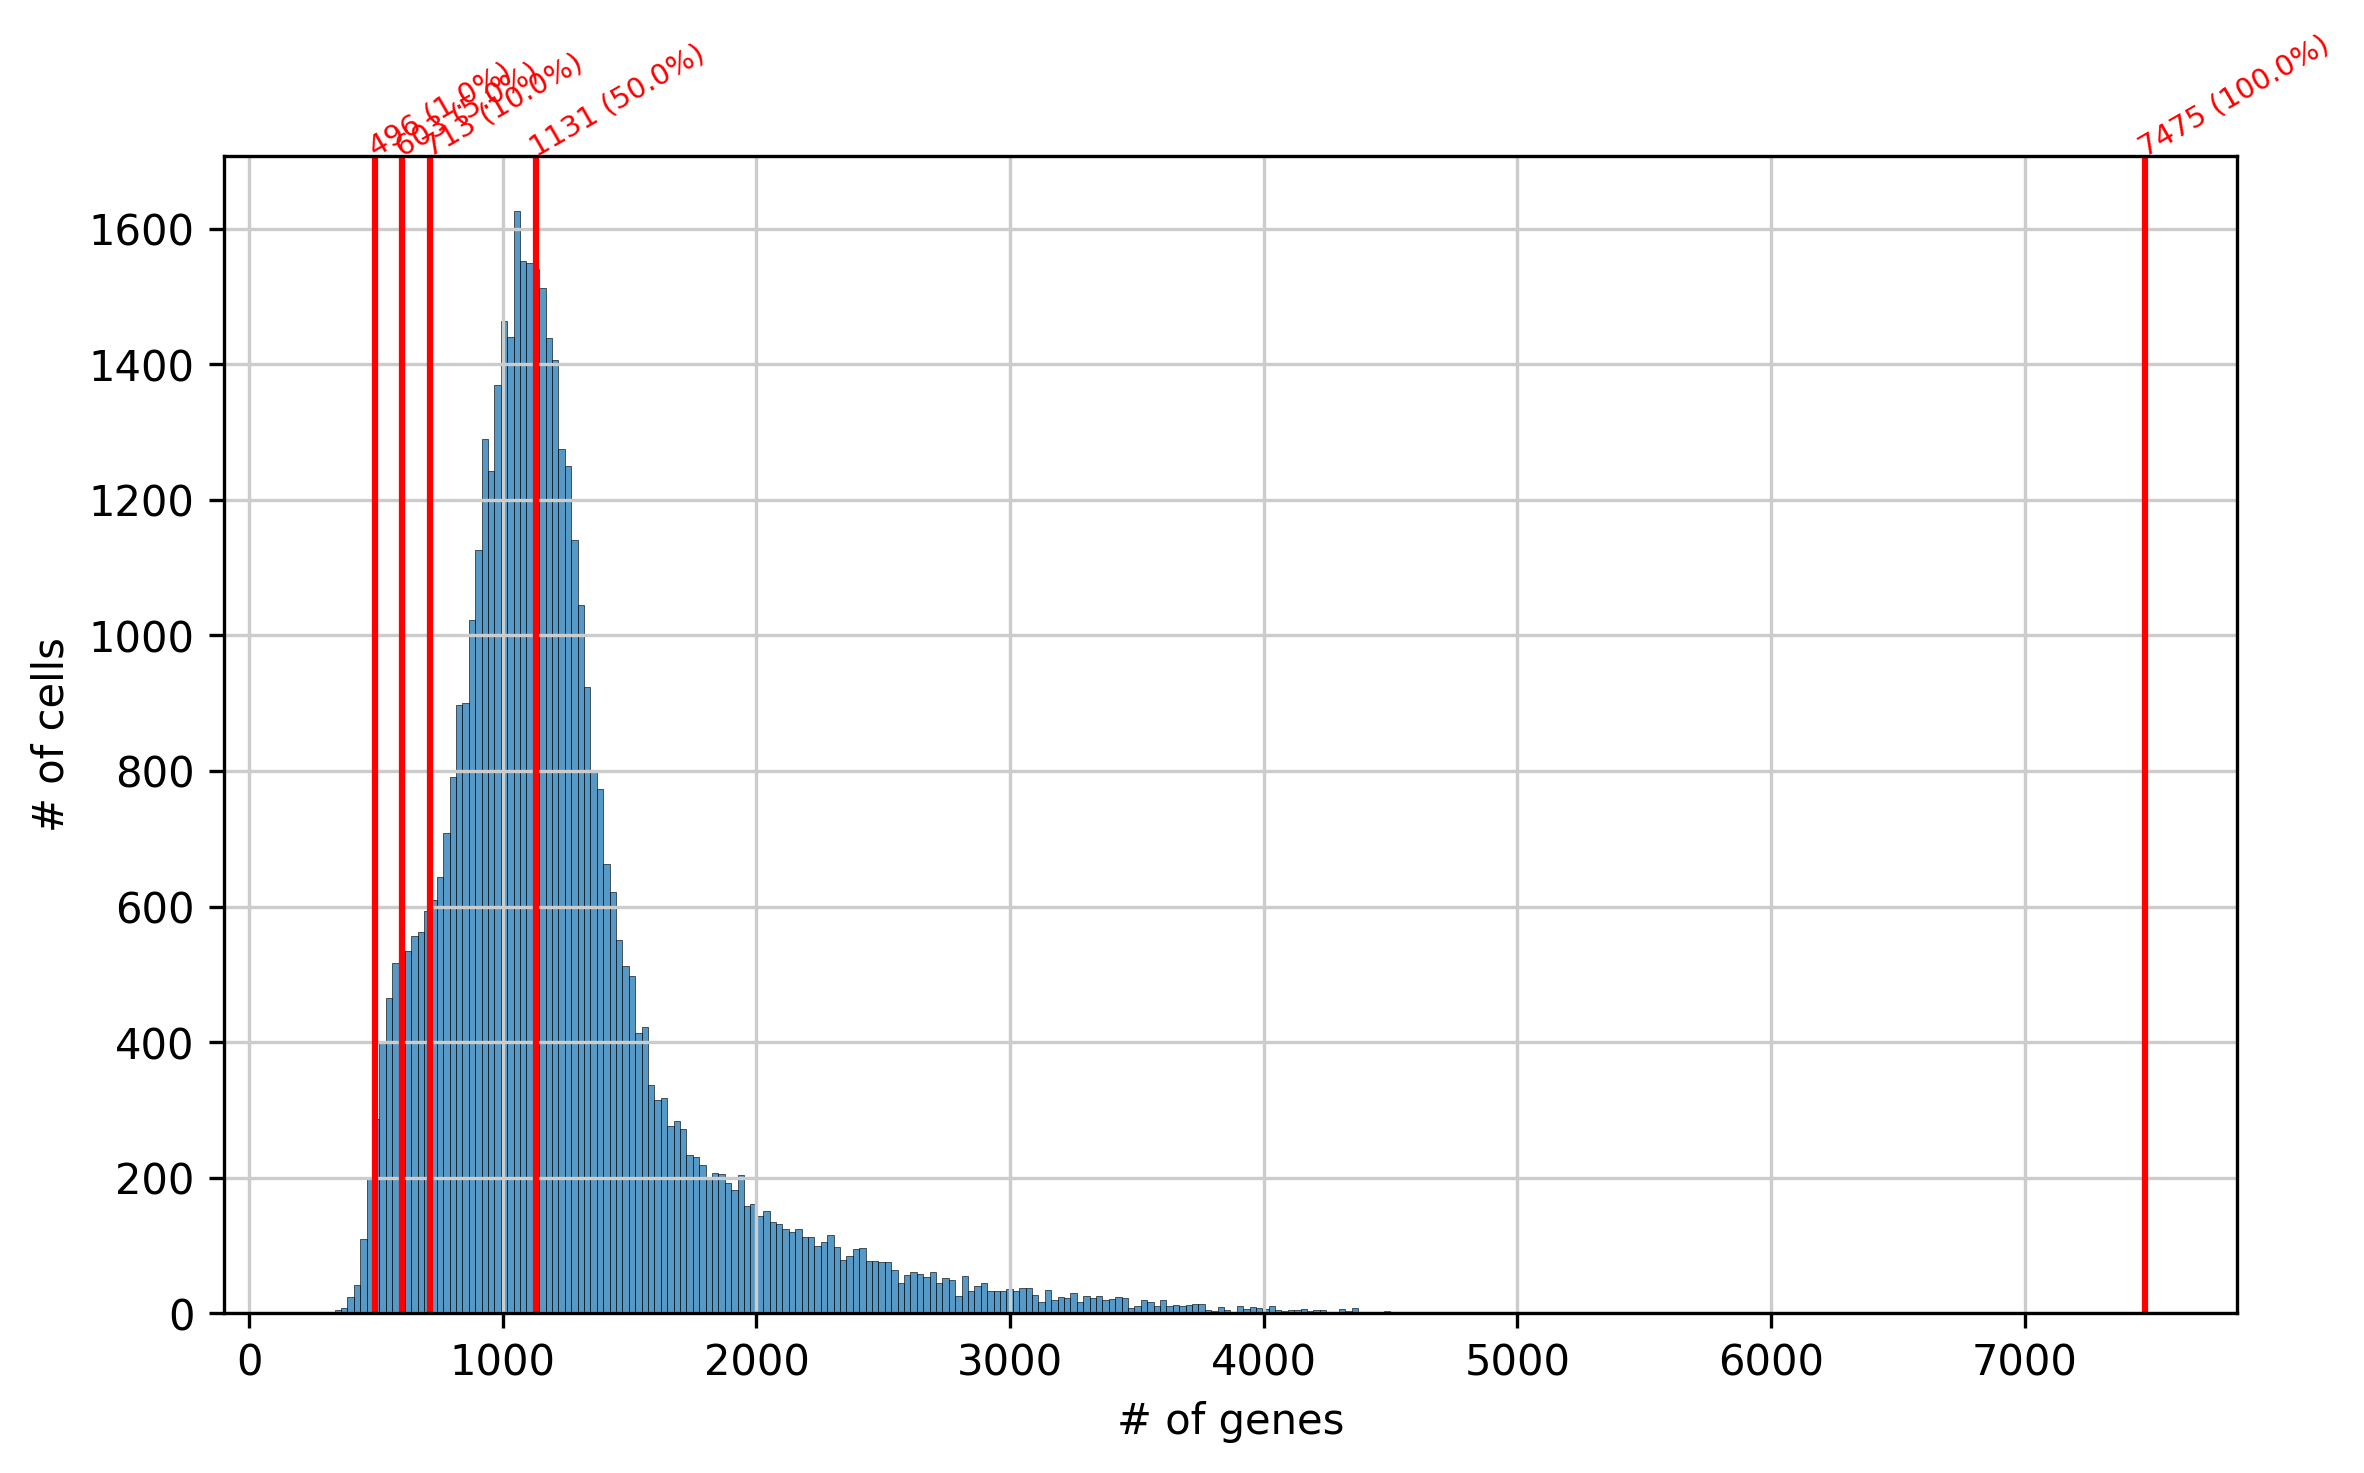

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.histplot(nGenesDetectedPerCell, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [9]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20


2025-04-21 18:04:10,213 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-04-21 18:04:48,682 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2025-04-21 18:04:48,706 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.
